In [ ]:
#hide
#default_exp visualization.plot_utils
from nbdev.showdoc import show_doc
import warnings
warnings.filterwarnings('ignore')

# Plot utilities

Allows to use matplotlib, ploty and visdom using the same API. This API is similar to the traditional one used in matplotlib

In [ ]:
#export
import plotly.graph_objs as go
import plotly.offline as offline
import numpy as np

def imshow (z, x=None, y=None, title=None, xlabel=None, ylabel=None):
    offline.init_notebook_mode (connected=True)
    
    trace = go.Heatmap(x=x, y=y, z=z)
    traces=[trace]
    dict_layout = dict()
    if title is not None:
        dict_layout.update(title=title)
    if xlabel is not None:
        dict_layout.update(xaxis=go.layout.XAxis(title=xlabel))
    if ylabel is not None:
        dict_layout.update(yaxis=go.layout.YAxis(title=ylabel))
        
    offline.iplot(dict(data=traces, layout=go.Layout(**dict_layout)))

In [ ]:
#export
def plot (x=None, y=None, style='b', label='', title=None, xlabel=None, ylabel=None, backend='plotly', figsize=(20,10), 
          fontsize=24, lw=3, markersize=20, window=None, traces=[]):
    if backend=='plotly':
        offline.init_notebook_mode (connected=True)
    elif backend=='visdom':
        import visdom
        vis = visdom.Visdom()
    elif backend=='matplotlib':
        import matplotlib.pyplot as plt
        if figsize is not None:
            plt.figure(figsize=figsize)
        else:
            plt.figure()
        if fontsize is not None:
            kw_font = dict(fontsize=fontsize)
            kw_font_dict = dict(fontdict=dict(fontsize=fontsize))
        else:
            kw_font = {}
            kw_font_dict = {}
        if lw is not None:
            kw_lw = dict(lw=lw)
        else:
            kw_lw = {}
        if markersize is not None:
            kw_lw.update (markersize=markersize)
    else:
        raise ValueError (f'backend {backend} not valid')
    
    assert (x is not None) or (y is not None) or (len(traces)>0), 'either x or y of traces should be given' 
    if (x is not None) or (y is not None):
        traces = add_trace (x, y, style, label = label, backend=backend, traces=traces)
    dict_layout = dict()
    if title is not None:
        dict_layout.update(title=title)
        
    if xlabel is not None:
        if backend=='plotly':
            dict_layout.update(xaxis=go.layout.XAxis(title=xlabel))
        elif backend=='visdom':
            dict_layout.update(xaxis={'title': xlabel})
        elif backend=='matplotlib':
            plt.xlabel(xlabel, **kw_font_dict)
        else:
            raise ValueError (f'backend {backend} not valid')
    if ylabel is not None:
        if backend=='plotly':
            dict_layout.update(yaxis=go.layout.YAxis(title=ylabel))
        elif backend=='visdom':
            dict_layout.update(yaxis={'title': ylabel})
        elif backend=='matplotlib':
            plt.ylabel(ylabel, **kw_font_dict)
        else:
            raise ValueError (f'backend {backend} not valid')
    
    if backend=='plotly':
        offline.iplot(dict(data=traces, layout=go.Layout(**dict_layout)))
    elif backend=='visdom':
        if window is None:
            window = title
        vis._send({'data': traces, 'layout': dict_layout, 'win': window})
    elif backend=='matplotlib':
        legend = []
        for trace in traces:
            plt.plot (trace['x'], trace['y'], trace['style'], label=trace['label'], **kw_lw)
            legend += [trace['label']]
        if fontsize is not None:
            plt.tick_params(axis='both', which='major', labelsize=fontsize)
        plt.legend (legend, **kw_font)
        plt.title (title, **kw_font_dict)
        plt.show()
    else:
        raise ValueError (f'backend {backend} not valid')
    
    return traces

In [ ]:
#export
def add_trace (x, y=None, style='b', label='', backend='plotly', marker = None, traces=[]):
    if y is None or type(y) is str:
        if type(y) is str:
            style = y
        y = x
        x = np.arange(len(y))
    d = symbol2marker (style)
    if type(x)==np.ndarray:
        x = x.ravel().tolist()
    if type(y)==np.ndarray:
        y = y.ravel().tolist()
    if marker is not None:
        d.update(marker=marker)
    if backend=='plotly':
        traces += [go.Scatter(x=x, y=y, name=label, **d)]
    elif backend=='visdom':
        traces += [dict(x=x, y=y, name=label, type='custom', **d)]
    elif backend=='matplotlib':
        import matplotlib.pyplot as plt
        
        if (len(style)>=1) and (style[0]=='A'):
            color = ['b','r', 'g', 'k', 'c', 'm', 'o', 'y']*100
            style=list(style)
            style[0] = color[len(traces)]
            style = ''.join(style)
        traces += [dict(x=x, y=y, style=style, label=label)]
    else:
        raise ValueError (f'backend {backend} not valid')
    
    return traces

In [ ]:
#export
def symbol2marker (symbol):
    if (symbol is None) or (len(symbol)==0):
        return dict(mode='lines')
    
    d = dict()
    if len(symbol) > 1 and ((symbol[-2:] == '.-') or (symbol[-2:] == '-.')):
        d.update(mode='markers+lines')
    elif len(symbol) > 1 and symbol[-2:] == '--':
        d.update(line=dict(dash='dash'))
    elif symbol[-1] == ':':
        d.update(line=dict(dash='dot'))
    elif symbol[-1] == '-':
        d.update(mode='lines')
    elif symbol[-1] == '.':
        d.update(mode='markers')
    else:
        d.update(mode='lines')
        
    if symbol[0]=='r':
        d.update(marker=dict(color='red'))
    elif symbol[0]=='b':
        d.update(marker=dict(color='blue'))
    elif symbol[0]=='c':
        d.update(marker=dict(color='cyan'))
    elif symbol[0]=='m':
        d.update(marker=dict(color='magenta'))
    elif symbol[0]=='k':
        d.update(marker=dict(color='black'))
    elif symbol[0]=='y':
        d.update(marker=dict(color = 'rgba(200, 200, 0, 1)'))
    elif symbol[0]=='g':
        d.update(marker=dict(color='green'))
    elif symbol[0]=='o':
        d.update(marker=dict(color='orange'))
    elif symbol[0]!='A':
        d.update(marker=dict(color='blue'))
        
    return d

In [ ]:
#export
def plot_df (df, x=None, message=None):

    offline.init_notebook_mode (connected=True)
    
    if message is not None:
        print (message)

    # show each individual time-series
    offline.iplot([
        {'x': df[x] if x is not None else df.index,
         'y': df[col],
         'name': col
        }  for col in df.columns])

## Some usage examples

### Assign colors using same syntax as in matplotlib

#### Use solid line without by default 

In [ ]:
traces = add_trace([1,2,3,30,60], 'b', label='first line', traces=[])
plot([10,20,30,40,100], 'y', label='second line', title='My title', xlabel = 'epochs', ylabel='percentage', traces=traces);

### Allow plotly / visdom to automatically assign colors

#### 1.- Use dotted line

In [ ]:
traces = add_trace([1,2,3,30,60], style='A:', traces=[])
plot([10,20,30,40,100], traces=traces, style='A:');

#### 2.- Use dashed line

In [ ]:
traces = add_trace([1,2,3,30,60], style='A--', traces=[])
plot([10,20,30,40,100], traces=traces, style='A--');

#### 3.- Use solie line

In [ ]:
traces = add_trace([1,2,3,30,60], style='A.-', traces=[])
plot([10,20,30,40,100], traces=traces, style='A.-');

## Plot using visdom

In [ ]:
traces = add_trace([1,2,3,30,60], style='A.-', label='first plot', backend='visdom', traces=[])
xtrace=plot([10,20,30,40,100], traces=traces, style='A.-', xlabel='epochs', ylabel='percentage', label='second plot', backend='visdom', title='visdom example');

Setting up a new session...


## Plot using matplotlib

### 1. first way

We add each line using `add_trace`, and then make the plot by calling the `plot` function with the rest of parameters 

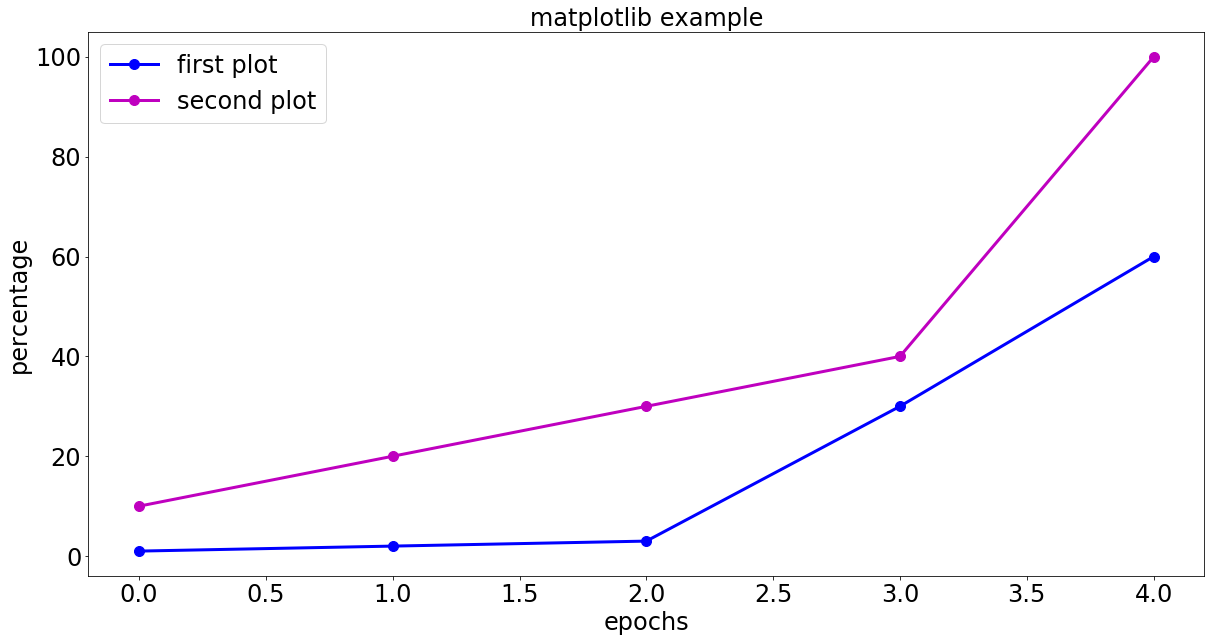

In [ ]:
traces = add_trace([1,2,3,30,60], style='b.-', label='first plot', backend='matplotlib', traces=[])
traces = add_trace([10,20,30,40,100], style='m.-', label='second plot', backend='matplotlib', traces=traces)
plot(xlabel='epochs', ylabel='percentage', 
     label='second plot', backend='matplotlib', title='matplotlib example', figsize=(20,10), 
     fontsize=24, lw=3, markersize=20, traces=traces);

### 2. second way

We add a first line using `add_trace` and add the second line and plot using `plot`

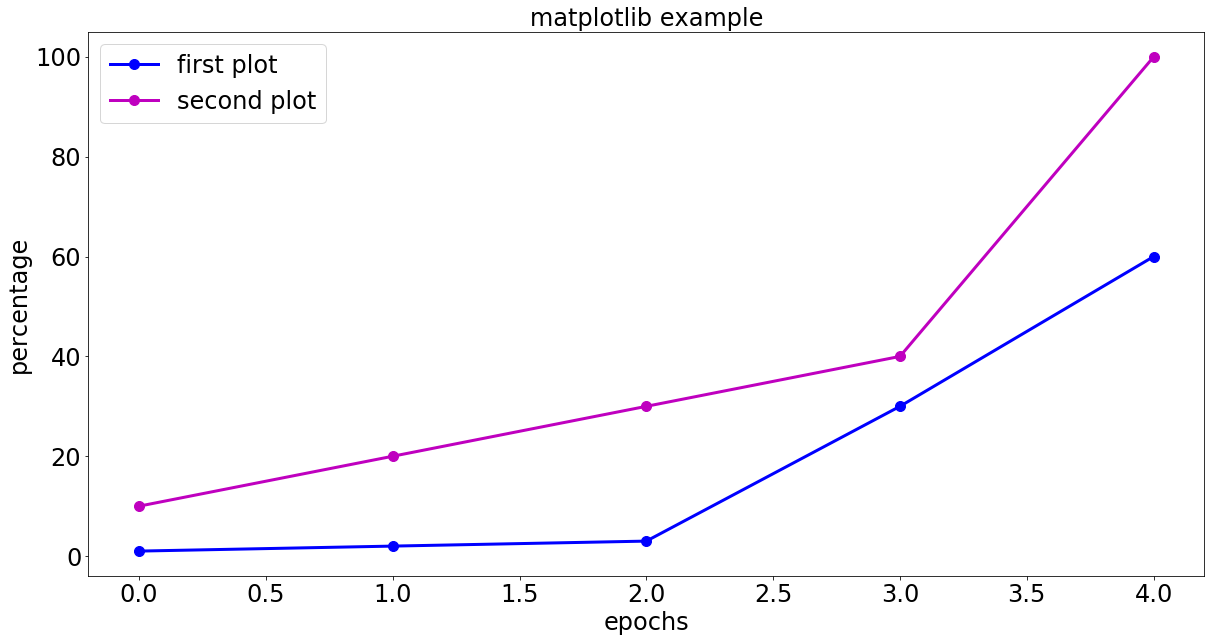

In [ ]:
traces = add_trace([1,2,3,30,60], style='b.-', label='first plot', backend='matplotlib', traces=[])
plot([10,20,30,40,100], style='m.-', xlabel='epochs', ylabel='percentage', 
     label='second plot', backend='matplotlib', title='matplotlib example', figsize=(20,10), 
     fontsize=24, lw=3, markersize=20, traces=traces);

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted query.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted metric_correlation.ipynb.
Converted plotly.ipynb.
